In [2]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
from IPython.display import Image

############ PRINT SVM INFO ################
C: 1
max_iter: 10000
epsilon: 0.01
kernel_type: linear

Accuracy: 0.5875


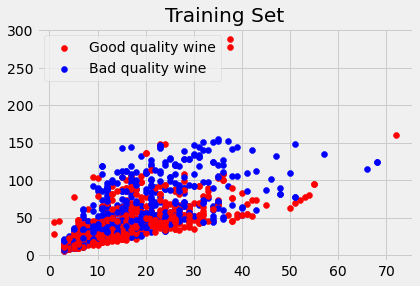

############ PRINT SVM INFO ################
C: 10
max_iter: 100
epsilon: 0.01
kernel_type: quadratic

Accuracy: 0.609375


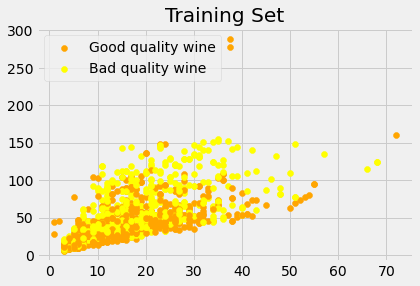

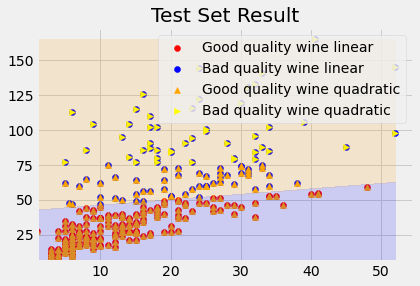

In [3]:
import csv
import numpy as np
import pandas as pd
import random as rnd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

x1_fixed_acidity = []
x2_volatile_acidity = []
x3_citric_acid = []
x4_residual_sugar = []
x5_chlorides = []
x6_free_sulfur_dioxide = []
x7_total_sulfur_dioxide = []
x8_density = []
x9_pH = []
x10_sulphates = []
x11_alcohol = []
Y_quality = []

################################################################################
def Read_Data(file_name):
    # getting the system path

    CSV_Data = csv.reader(open(file_name, newline=''))

    isHeading = True

    for row in CSV_Data:
        # skip the first row of csv file
        if isHeading == True:
            isHeading = False
            continue

        x1_fixed_acidity.append(float(row[1]))
        x2_volatile_acidity.append(float(row[2]))
        x3_citric_acid.append(float(row[3]))
        x4_residual_sugar.append(float(row[4]))
        x5_chlorides.append(float(row[5]))
        x6_free_sulfur_dioxide.append(float(row[6]))
        x7_total_sulfur_dioxide.append(float(row[7]))
        x8_density.append(float(row[8]))
        x9_pH.append(float(row[9]))
        x10_sulphates.append(float(row[10]))
        x11_alcohol.append(float(row[11]))
        wine_quality = 0
        if (row[12] == '3'):
            wine_quality = -1
        if (row[12] == '4'):
            wine_quality = -1
        if (row[12] == '5'):
            wine_quality = -1
        if (row[12] == '6'):
            wine_quality = 1
        if (row[12] == '7'):
            wine_quality = 1
        if (row[12] == '8'):
            wine_quality = 1
        Y_quality.append(wine_quality)
################################################################################

################################################################################
def Create_Matrix():
    Array_fixed_acidity = np.array(x1_fixed_acidity)
    Array_volatile_acidity = np.array(x2_volatile_acidity)
    Array_citric_acid = np.array(x3_citric_acid)
    Array_residual_sugar = np.array(x4_residual_sugar)
    Array_chlorides = np.array(x5_chlorides)
    Array_free_sulfur_dioxide = np.array(x6_free_sulfur_dioxide)
    Array_total_sulfur_dioxide = np.array(x7_total_sulfur_dioxide)
    Array_density = np.array(x8_density)
    Array_pH = np.array(x9_pH)
    Array_sulphates = np.array(x10_sulphates)
    Array_alcohol = np.array(x11_alcohol)

    global Wine_Feature_Matrix
    Wine_Feature_Matrix = np.column_stack(
        (Array_fixed_acidity, Array_volatile_acidity, Array_citric_acid, Array_residual_sugar, Array_chlorides, Array_free_sulfur_dioxide, Array_total_sulfur_dioxide, Array_density, Array_pH, Array_sulphates, Array_alcohol))
################################################################################

################################################################################
class SVM():
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, epsilon=0.001):
        self.kernels = {
            'linear': self.kernel_linear,
            'quadratic': self.kernel_quadratic
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.epsilon = epsilon

    def fit(self, X, y):
        # n : number of samples (100)
        n = X.shape[0]

        # we have alpha per sample of training set. Initially set to zeros
        alpha = np.zeros((n))

        # pick the kernel user selected
        kernel = self.kernels[self.kernel_type]

        iteration = 0
        while True:
            iteration += 1

            # saving the copy of alpha from previous iteration
            alpha_prev = np.copy(alpha)

            # going through all the samples in one iteration
            for j in range(0, n):

                # selcting random sample index where i is not equal to j
                i = self.get_rnd_int(0, n - 1, j)  # Get random int i~=j

                x_i = X[i, :]
                x_j = X[j, :]
                y_i = y[i]
                y_j = y[j]

                k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)

                if k_ij == 0:
                    continue

                # select alpha of i and j from the alpha array to calculate L and H
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                (L, H) = self.compute_L_H(self.C, alpha_prime_j, alpha_prime_i, y_j, y_i)

                # Compute model parameters
                self.w = self.calc_w(alpha, y, X)
                self.b = self.calc_b(X, y, self.w)

                # Compute E_i, E_j
                E_i = self.E(x_i, y_i, self.w, self.b)
                E_j = self.E(x_j, y_j, self.w, self.b)

                # Set new alpha values
                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j)) / k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i * y_j * (alpha_prime_j - alpha[j])

            # Terminating condition: reacing convergence
            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            # Terminating condition: Reaching max iterations
            if iteration >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return

        # Compute final model parameters
        self.b = self.calc_b(X, y, self.w)
        if self.kernel_type == 'linear':
            self.w = self.calc_w(alpha, y, X)

    def predict(self, X):
        return self.h(X, self.w, self.b)

    def calc_b(self, X, y, w):
        b_tmp = y - np.dot(w.T, X.T)
        return np.mean(b_tmp)

    def calc_w(self, alpha, y, X):
        return np.dot(alpha * y, X)

    # Prediction
    def h(self, X, w, b):
        return np.sign(np.dot(w.T, X.T) + b).astype(int)

    # Prediction error
    def E(self, x_k, y_k, w, b):
        return self.h(x_k, w, b) - y_k

    def compute_L_H(self, C, alpha_prime_j, alpha_prime_i, y_j, y_i):
        if (y_i != y_j):
            return (max(0, alpha_prime_j - alpha_prime_i), min(C, C - alpha_prime_i + alpha_prime_j))
        else:
            return (max(0, alpha_prime_i + alpha_prime_j - C), min(C, alpha_prime_i + alpha_prime_j))

    def get_rnd_int(self, a, b, z):
        i = z
        cnt = 0
        while i == z and cnt < 1000:
            i = rnd.randint(a, b)
            cnt = cnt + 1
        return i

    # Define kernels
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)

    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)

    # Printing out the parameters of SVM
    def print_info(self):
        print("############ PRINT SVM INFO ################")
        print("C:", self.C)
        print("max_iter:", self.max_iter)
        print("epsilon:", self.epsilon)
        print("kernel_type:", self.kernel_type)
################################################################################

################################################################################
def calc_acc(y, y_hat):
    correct_counter = 0
    for i in range(0, len(y)):
        if (y[i] == -1 and y_hat[i] == -1):
            correct_counter = correct_counter + 1
        if (y[i] == 1 and y_hat[i] == 1):
            correct_counter = correct_counter + 1

    return (correct_counter / len(y))
################################################################################

def main_q():
    Read_Data('winequality-red-svm-scratch.csv')
    Create_Matrix()

    C = 10
    max_iter = 100
    epsilon = 0.01
    kernel_type = 'quadratic'

    model = SVM(max_iter, kernel_type, C, epsilon)

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(Wine_Feature_Matrix[:,[5,6]], Y_quality, test_size=0.2, random_state=0)

    global support_vectors
    model.fit(X_train, y_train)

    # Make prediction
    y_hat = model.predict(X_test)

    # Calculate accuracy
    accuracy = calc_acc(y_test, y_hat)

    model.print_info()
    print("\nAccuracy:", accuracy)
    for i in range(0, len(y_train)):
        if y_train[i] == 1:
            c1 = plt.scatter(X_train[i, 0], X_train[i, 1], c='r')
        else:
            c2 = plt.scatter(X_train[i, 0], X_train[i, 1], c='b')
    plt.title("Training Set")
    plt.legend([c1, c2], ['Good quality wine', 'Bad quality wine'])
    plt.show()

    for i in range(0, len(y_hat)):
        if y_hat[i] == 1:
            c1 = plt.scatter(X_test[i, 0], X_test[i, 1], c='r')
        else:
            c2 = plt.scatter(X_test[i, 0], X_test[i, 1], c='b')
    plt.title("Test Set Result")
    plt.legend([c1, c2], ['Good quality wine', 'Bad quality wine'])
    
    from matplotlib.colors import ListedColormap
    X_set, y_set = X_test, y_hat

    aranged_x0 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
    aranged_x1 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

    X1, X2 = np.meshgrid(aranged_x0, aranged_x1)
    plt.contourf(X1, X2, model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.15, cmap = ListedColormap(('orange', 'blue')))


################################################################################
def main():
    Read_Data('winequality-red-svm-scratch.csv')
    Create_Matrix()
    
    #linear
    C = 1
    max_iter = 10000
    epsilon = 0.01
    kernel_type = 'linear'

    model = SVM(max_iter, kernel_type, C, epsilon)

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(Wine_Feature_Matrix[:,[5,6]], Y_quality, test_size=0.2, random_state=0)

    global support_vectors
    model.fit(X_train, y_train)

    # Make prediction
    y_hat = model.predict(X_test)

    # Calculate accuracy
    accuracy = calc_acc(y_test, y_hat)

    model.print_info()
    print("\nAccuracy:", accuracy)
    for i in range(0, len(y_train)):
        if y_train[i] == 1:
            c1 = plt.scatter(X_train[i, 0], X_train[i, 1], c='r')
        else:
            c2 = plt.scatter(X_train[i, 0], X_train[i, 1], c='b')
    plt.title("Training Set")
    plt.legend([c1, c2], ['Good quality wine', 'Bad quality wine'])
    plt.show()
    
    #quadratic
    C1 = 10
    max_iter1 = 100
    epsilon1 = 0.01
    kernel_type1 = 'quadratic'

    model1 = SVM(max_iter1, kernel_type1, C1, epsilon1)
    
    from sklearn.model_selection import train_test_split

    X_train1, X_test1, y_train1, y_test1 = train_test_split(Wine_Feature_Matrix[:,[5,6]], Y_quality, test_size=0.2, random_state=0)

    global support_vectors
    model1.fit(X_train1, y_train1)

    # Make prediction
    y_hat1 = model1.predict(X_test1)

    # Calculate accuracy
    accuracy1 = calc_acc(y_test1, y_hat1)

    model1.print_info()
    print("\nAccuracy:", accuracy1)
    for i in range(0, len(y_train1)):
        if y_train1[i] == 1:
            c1 = plt.scatter(X_train1[i, 0], X_train1[i, 1], c='orange')
        else:
            c2 = plt.scatter(X_train1[i, 0], X_train1[i, 1], c='yellow')
    plt.title("Training Set")
    plt.legend([c1, c2], ['Good quality wine', 'Bad quality wine'])
    plt.show()
    
    #TEST RESULTS
    for i in range(0, len(y_hat)):
        if y_hat[i] == 1:
            c1 = plt.scatter(X_test[i, 0], X_test[i, 1], c='red')
        else:
            c2 = plt.scatter(X_test[i, 0], X_test[i, 1], c='blue')
    for j in range(0, len(y_hat1)):
        if y_hat1[j] == 1:
            c3 = plt.scatter(X_test1[j, 0], X_test1[j, 1], c='orange',marker='^')
        else:
            c4 = plt.scatter(X_test1[j, 0], X_test1[j, 1], c='yellow',marker='>')
    from matplotlib.colors import ListedColormap
    X_set, y_set = X_test, y_hat

    aranged_x0 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
    aranged_x1 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

    X1, X2 = np.meshgrid(aranged_x0, aranged_x1)
    plt.contourf(X1, X2, model.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.15, cmap = ListedColormap(('orange', 'blue')))
    plt.title("Test Set Result")
    plt.legend([c1, c2, c3, c4], ['Good quality wine linear', 'Bad quality wine linear', 'Good quality wine quadratic', 'Bad quality wine quadratic'])
    plt.show()
    
################################################################################

################################################################################
if __name__ == "__main__":
    #main_q()
    main()

In [4]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [5]:
wine = pd.read_csv('winequality-red.csv')

In [6]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [7]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [8]:
bins = (1,5,10)
group_names = [1,2]
wine['quality'] = pd.cut(wine['quality'], bins = bins, labels = group_names)

In [9]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,2
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,1
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,2
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,2
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,1


In [ ]:
sns.pairplot(wine)

In [ ]:
X = np.array(wine.iloc[:, [5, 6]])
y = np.array(wine.iloc[:, 11])

In [ ]:
# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X, y)

In [ ]:
pred_svc = classifier.predict([[3,16]])
print(pred_svc)

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
# Fitting SVM to the Training set
from sklearn.svm import SVC,LinearSVC
classifier = LinearSVC()

classifier.fit(X_train, y_train)

In [ ]:
pred_svc = classifier.predict(X_test)
print("Accuracy :",metrics.accuracy_score(y_test, pred_svc) * 100, "% \n")
print("Classification report : \n",metrics.classification_report(y_test, pred_svc), "\n")

In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, pred_svc

aranged_x0 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
aranged_x1 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

X1, X2 = np.meshgrid(aranged_x0, aranged_x1)
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
     alpha = 0.15, cmap = ListedColormap(('orange', 'blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM Linear Kernel (Test set)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend()
plt.show()

In [ ]:
# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', gamma = 0.03,random_state = 0)
classifier.fit(X_train, y_train)

In [ ]:
pred_svc = classifier.predict(X_test)
print("Accuracy :",metrics.accuracy_score(y_test, pred_svc) * 100, "% \n")
print("Classification report : \n",metrics.classification_report(y_test, pred_svc), "\n")

In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, pred_svc

aranged_x0 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
aranged_x1 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

X1, X2 = np.meshgrid(aranged_x0, aranged_x1)
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
     alpha = 0.05, cmap = ListedColormap(('orange', 'blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM RBF Kernel (Test set)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend()
plt.show()

In [ ]:
# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'poly', random_state = 0, degree = 3)
classifier.fit(X_train, y_train)

In [ ]:
pred_svc = classifier.predict(X_test)
print("Accuracy :",metrics.accuracy_score(y_test, pred_svc) * 100, "% \n")
print("Classification report : \n",metrics.classification_report(y_test, pred_svc), "\n")

In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, pred_svc

aranged_x0 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
aranged_x1 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

X1, X2 = np.meshgrid(aranged_x0, aranged_x1)
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
     alpha = 0.05, cmap = ListedColormap(('orange', 'blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM Polynomial Kernel (Test set)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend()
plt.show()

In [ ]:
# Fitting SVM to the Training set
from sklearn.svm import SVC
classifier = SVC(kernel = 'sigmoid', random_state = 0)
classifier.fit(X_train, y_train)

In [ ]:
pred_svc = classifier.predict(X_test)
print("Accuracy :",metrics.accuracy_score(y_test, pred_svc) * 100, "% \n")
print("Classification report : \n",metrics.classification_report(y_test, pred_svc), "\n")

In [ ]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, pred_svc

aranged_x0 = np.arange(start = X_set[:, 0].min(), stop = X_set[:, 0].max(), step = 0.01)
aranged_x1 = np.arange(start = X_set[:, 1].min(), stop = X_set[:, 1].max(), step = 0.01)

X1, X2 = np.meshgrid(aranged_x0, aranged_x1)
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
     alpha = 0.15, cmap = ListedColormap(('orange', 'blue')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green','yellow'))(i), label = j)
plt.title('SVM Sigmoid Kernel (Test set)')
plt.xlabel('x0')
plt.ylabel('x1')
plt.legend()
plt.show()

In [ ]:
from sklearn.svm import LinearSVC,SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

models=[LinearSVC(),SVC(kernel = 'rbf', random_state = 0),SVC(kernel = 'poly', random_state = 0, degree = 3),SVC(kernel = 'sigmoid', random_state = 0),
        KNeighborsClassifier(),RandomForestClassifier(),
        DecisionTreeClassifier(),GradientBoostingClassifier(),GaussianNB()]

model_names=['LinearSVM','rbfSVM','polySVM','sigmoidSVM','KNearestNeighbors','RandomForestClassifier','DecisionTree',
             'GradientBoostingClassifier','GaussianNB']
acc=[]
d={}
for model in range(len(models)):
    clf=models[model]
    clf.fit(X_train,y_train)
    pred=clf.predict(X_test)
    acc.append(accuracy_score(pred,y_test))
     
d={'Modelling Algo':model_names,'Accuracy':acc}
acc_frame=pd.DataFrame(d)
acc_frame.loc['9'] = ['Quadratic_SVM_from_scratch', '0.628125']
acc_frame.loc['10'] = ['Linear_SVM_from_scratch', '0.58125']

In [29]:
acc_frame

,Modelling Algo,Accuracy
0,LinearSVM,0.615
1,rbfSVM,0.615
2,polySVM,0.5525
3,sigmoidSVM,0.5025
4,KNearestNeighbors,0.5975
5,RandomForestClassifier,0.6325
6,DecisionTree,0.615
7,GradientBoostingClassifier,0.63
8,GaussianNB,0.58
9,Quadratic_SVM_from_scratch,0.628125
